In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import numpy as np

import torch

import utils
import network

import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from cleanplots import *

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import cv2
cap = cv2.VideoCapture("vtest.avi")

frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # 转灰度
    frames.append(gray)

cap.release()

video_np = np.array(frames)  # shape = (N, H, W)
print(video_np.shape)

(795, 576, 768)


In [34]:
image_seq = video_np[0:10,100:360,220:720].astype(np.float32) / 255

interactive(children=(IntSlider(value=0, description='i', max=9), Output()), _dom_classes=('widget-interact',)…

<function __main__.updateFrame(i)>

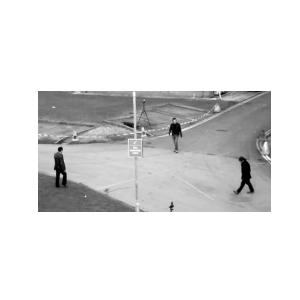

In [35]:
f, ax = plt.subplots(1, 1, figsize=(3, 3))

def init():
    ax.imshow(image_seq[0], cmap='gray')
    ax.axis('off')

init()

def updateFrame(i):
    ax.imshow(image_seq[i], cmap='gray')
    ax.axis('off')

interact(updateFrame, i=IntSlider(min=0, max=image_seq.shape[0]-1, step=1, value=0))

# Learning

In [36]:
raw_data = image_seq

half_dt = 0.5 / (raw_data.shape[0] - 1)
half_dy = 0.5 / raw_data.shape[1]
half_dx = 0.5 / raw_data.shape[2]

ts = torch.linspace(half_dt, 1-half_dt, raw_data.shape[0]-1)
ys = torch.linspace(half_dy, 1-half_dy, raw_data.shape[1])
xs = torch.linspace(half_dx, 1-half_dx, raw_data.shape[2])
tv, yv, xv = torch.meshgrid([ts, ys, xs], indexing='ij')
tyx = torch.stack([tv.flatten(), yv.flatten(), xv.flatten()]).t()

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = network.motion_model().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [44]:
T, H, W = raw_data.shape
y, x = torch.meshgrid(torch.arange(H), torch.arange(W), indexing="ij")
grid = torch.stack((x, y), dim=-1).float().to(device)  # [H, W, 2]

In [45]:
tyx = tyx.reshape(T-1, H, W, 3)
tyx.shape

torch.Size([9, 260, 500, 3])

In [46]:
from tqdm import tqdm
import losses

max_epoch = 10000
epochs = tqdm(range(max_epoch))

raw_data_torch = torch.from_numpy(raw_data)

for n_steps in epochs:
    sin_epoch = min(1.0, 0.05+np.sin(n_steps/(max_epoch - 1)*np.pi/2))

    random_idx = np.random.randint(0, raw_data.shape[0]-1) # pick up a random frame from [0, raw_data.shape[0]-1)
    origin_data_tensor = raw_data_torch[random_idx].to(device)
    final_data_tensor = raw_data_torch[random_idx+1].to(device)

    tyx_selected = tyx[random_idx].reshape(-1,3).to(device)
    flow = model(tyx_selected, sin_epoch)
    flow = flow.reshape(H, W, 2)
    warped = utils.warp(origin_data_tensor, flow, grid)

    mse_loss = torch.abs((warped - final_data_tensor))**2

    loss = mse_loss.mean() + 0.01*losses.tv_reg_flow_2d(flow)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epochs.set_postfix(loss=loss.item())


  0%|          | 0/10000 [00:00<?, ?it/s, loss=0.0157] 

100%|██████████| 10000/10000 [00:33<00:00, 294.57it/s, loss=0.000404]


In [47]:
flow_all = []
warped_all = []
origin_all = []
final_all = []

with torch.no_grad():
    for i in range(raw_data.shape[0]-1):
        tyx_selected = tyx[i].reshape(-1,3).to(device)
        origin_data_tensor = raw_data_torch[i].to(device)
        final_data_tensor = raw_data_torch[i+1].to(device)
        flow = model(tyx_selected, 1.0)
        flow = flow.reshape(H, W, 2)
        warped = utils.warp(origin_data_tensor, flow, grid)
        flow_all.append(flow.detach().cpu().numpy())
        warped_all.append(warped.detach().cpu().numpy())
        origin_all.append(origin_data_tensor.detach().cpu().numpy())
        final_all.append(final_data_tensor.detach().cpu().numpy())
flow_all = np.array(flow_all)
warped_all = np.array(warped_all)
origin_all = np.array(origin_all)
final_all = np.array(final_all)

interactive(children=(IntSlider(value=0, description='i', max=8), Output()), _dom_classes=('widget-interact',)…

<function __main__.updateFrame(i)>

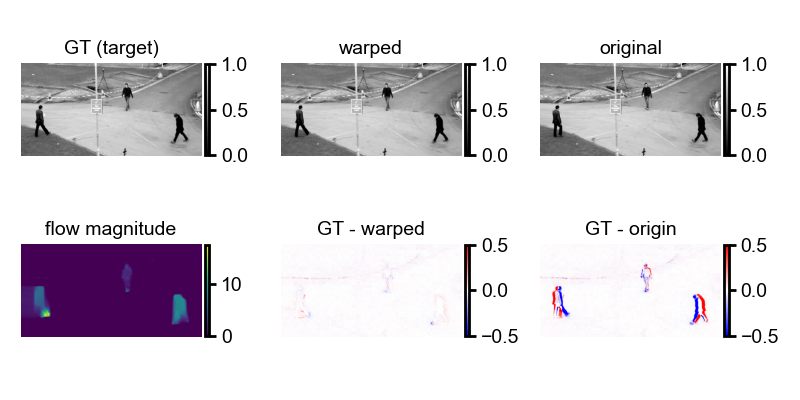

In [ ]:
f, ax = plt.subplots(2,3,figsize=(8,4))

ims = {}

def init():
    ims['gt'] = ax[0,0].imshow(final_all[0], cmap="gray")
    ax[0,0].axis('off'); ax[0,0].set_title('GT (target)')
    f.colorbar(ims['gt'], ax=ax[0,0], fraction=0.024, pad=0.02)  
    
    ims['warped'] = ax[0,1].imshow(warped_all[0], cmap="gray")
    ax[0,1].axis('off'); ax[0,1].set_title('warped')
    f.colorbar(ims['warped'], ax=ax[0,1], fraction=0.024, pad=0.02)  
    
    ims['origin'] = ax[0,2].imshow(origin_all[0], cmap="gray")
    ax[0,2].axis('off'); ax[0,2].set_title('original')
    f.colorbar(ims['origin'], ax=ax[0,2], fraction=0.024, pad=0.02) 
    
    ims['flow'] = ax[1,0].imshow(np.linalg.norm(flow_all[0], axis=-1), cmap="viridis")
    ax[1,0].axis('off'); ax[1,0].set_title('flow magnitude')
    f.colorbar(ims['flow'], ax=ax[1,0], fraction=0.024, pad=0.02) 
    
    ims['diff_warped'] = ax[1,1].imshow(final_all[0] - warped_all[0], cmap="bwr", vmin=-0.5, vmax=0.5)
    ax[1,1].axis('off'); ax[1,1].set_title('GT - warped')
    f.colorbar(ims['diff_warped'], ax=ax[1,1], fraction=0.024, pad=0.02)  
    
    ims['diff_origin'] = ax[1,2].imshow(final_all[0] - origin_all[0], cmap="bwr", vmin=-0.5, vmax=0.5)
    ax[1,2].axis('off'); ax[1,2].set_title('GT - origin')
    f.colorbar(ims['diff_origin'], ax=ax[1,2], fraction=0.024, pad=0.02) 
    f.tight_layout()

def updateFrame(i):
    ims['gt'].set_data(final_all[i])
    ims['warped'].set_data(warped_all[i])
    ims['origin'].set_data(origin_all[i])
    ims['flow'].set_data(np.linalg.norm(flow_all[i], axis=-1))
    ims['diff_warped'].set_data(final_all[i] - warped_all[i])
    ims['diff_origin'].set_data(final_all[i] - origin_all[i])
    f.canvas.draw_idle()

init()
interact(updateFrame, i=IntSlider(min=0, max=raw_data.shape[0]-2, step=1, value=0))